# Crowd counting using CSRNet (Dilated Convolutional Neural Network)

## Initialization

In [1]:
# Install required libraries
!pip install -U scipy torch_snippets torch_summary h5py
!git clone https://github.com/sizhky/CSRNet-pytorch.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 14.8 MB/s eta 0:00

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (92/92), 623.74 KiB | 2.01 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [67]:
# Import libraries
import os
from pathlib import Path
import h5py
from scipy.io import loadmat
import numpy as np

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from torchvision import transforms as T
from torch_snippets import *

from sklearn.model_selection import train_test_split
from google.colab import files

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm as c

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Sat Mar 16 01:54:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              29W /  70W |    185MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [5]:
# Upload Kaggle Token
files.upload()

# Copy Kaggle Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [29]:
# Download and extract the dataset
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
!unzip -qq shanghaitech-with-people-density-map.zip -d shanghaitech-with-people-density-map

100% 4.77G/4.79G [00:41<00:00, 205MB/s]
100% 4.79G/4.79G [00:41<00:00, 123MB/s]


In [35]:
# Create a symlink to the dataset
%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map

from utils import save_net, load_net

/content/CSRNet-pytorch


In [41]:
part_A_train_path = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/'
part_A = Glob(part_A_train_path)

image_folder = f'{part_A_train_path}/images/'
heatmap_folder = f'{part_A_train_path}/ground-truth-h5/'
gt_folder = f'{part_A_train_path}/ground-truth/'

In [68]:
# Create Dataset class to fetch images and labels
transforms = T.Compose([
    T.ToTensor()
])

class CrowdsDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        stem = self.files[idx]
        image_path = f'{image_folder}/{stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{stem}.h5'
        gt_path = f'{gt_folder}/GT_{stem}.mat'

        # Load ground truth data (.mat file) and get the number of people in the image
        mat = loadmat(gt_path)
        points = len(mat['image_info'][0,0][0,0][0])

        # Read image and ground truth density map
        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8) * 64 # Output size is 1/8 of input size, so multiply by 64 to get the original count

        return image.copy(), gt.copy(), points

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([transforms(im)[None] for im in ims]).to(device)
        gts = torch.cat([transforms(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

In [69]:
# Create the train and validation datasets
train_stems, val_stems = train_test_split([Path(full_path).stem for full_path in Glob(image_folder)], random_state=44)

train_ds = CrowdsDataset(train_stems)
val_ds = CrowdsDataset(val_stems)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 1):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn)
    return train_dl, val_dl

In [70]:
# Create a function to perform dilated convolutions
def make_layers(cfg, in_channels = 3, batch_norm=False, dilation = False):
    d_rate = 2 if dilation else 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [71]:
# Create a class for the CSRNet model
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super().__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels = 512, dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(weights='IMAGENET1K_V1')
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]

    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [72]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, gts, _ = data
    pred_gts = model(images)
    loss = criterion(pred_gts, gts)
    pts_loss = nn.L1Loss()(pred_gts.sum(), gts.sum())
    loss.backward()
    optimizer.step()
    return loss.item(), pts_loss.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, gts, _ = data
    _gts = model(images)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [73]:
# Train the model
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
train_dl, val_dl = load_data()
n_epochs = 20

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, pts_loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, train_pts_loss=pts_loss, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(epoch+1)

EPOCH: 1.000  train_pts_loss: 442.523  val_loss: 0.034  val_pts_loss: 282.886  train_loss: 0.056  (87.00s - 1652.96s remaining)
EPOCH: 2.000  train_pts_loss: 324.494  val_loss: 0.030  val_pts_loss: 227.490  train_loss: 0.047  (170.03s - 1530.24s remaining)
EPOCH: 3.000  train_pts_loss: 225.729  val_loss: 0.026  val_pts_loss: 179.007  train_loss: 0.041  (253.37s - 1435.78s remaining)
EPOCH: 4.000  train_pts_loss: 166.679  val_loss: 0.027  val_pts_loss: 158.870  train_loss: 0.038  (336.72s - 1346.89s remaining)
EPOCH: 5.000  train_pts_loss: 150.636  val_loss: 0.025  val_pts_loss: 133.779  train_loss: 0.036  (419.93s - 1259.79s remaining)
EPOCH: 6.000  train_pts_loss: 150.301  val_loss: 0.025  val_pts_loss: 157.057  train_loss: 0.036  (503.48s - 1174.80s remaining)
EPOCH: 7.000  train_pts_loss: 142.704  val_loss: 0.024  val_pts_loss: 125.710  train_loss: 0.035  (586.66s - 1089.51s remaining)
EPOCH: 8.000  train_pts_loss: 138.394  val_loss: 0.024  val_pts_loss: 124.947  train_loss: 0.034  

100%|██████████| 121/121 [00:00<00:00, 442.27it/s]


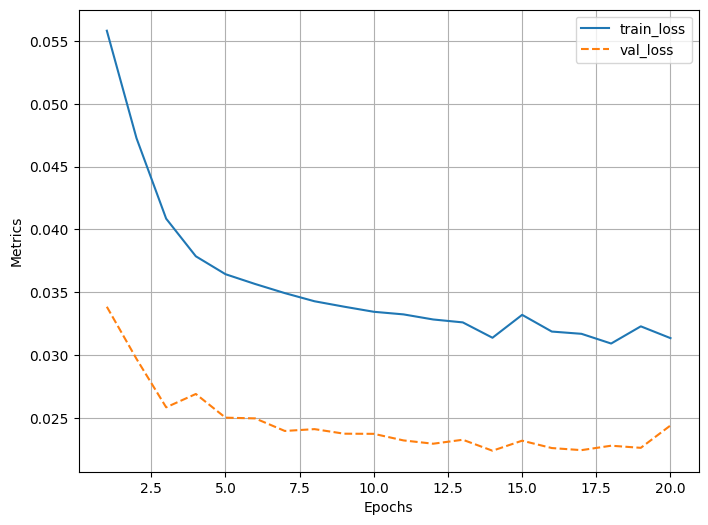

100%|██████████| 121/121 [00:00<00:00, 378.63it/s]


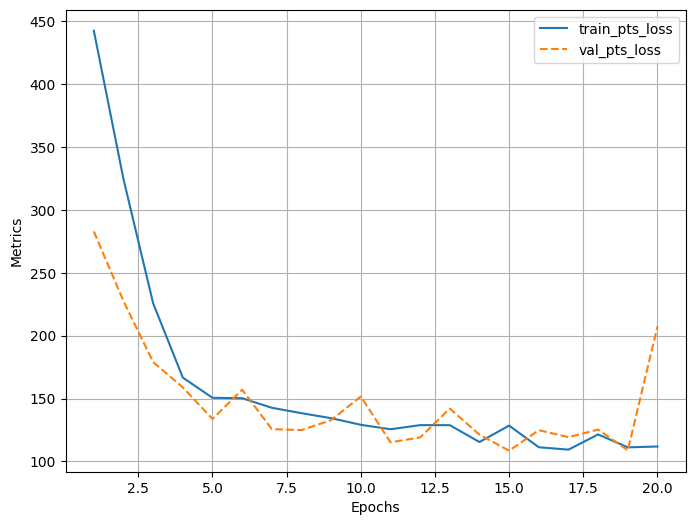

In [78]:
# Plot Training history
log.plot_epochs(['train_loss', 'val_loss'])
log.plot_epochs(['train_pts_loss', 'val_pts_loss'])

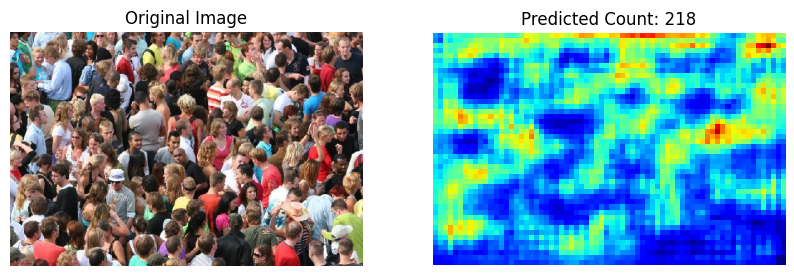

In [98]:
# Set a transform to normalize the image
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Select a random image from the test set and normalize it
test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
images = Glob(f'{test_folder}/images')
image_path = choose(images)
image = transform(Image.open(image_path).convert('RGB')).to(device)

# Make a prediction on the test image
output = model(image[None])
pred_count = int(output.detach().cpu().sum().numpy())

# Display the test image
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(temp, cmap = c.jet)
plt.title(f'Predicted Count: {pred_count}')
plt.axis('off')
plt.show()